In [1]:
import numpy as np

# Importing standard Qiskit libraries
import qiskit
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Importing PyTorch libraries
import torch
from torch.autograd import Function # we will have to define our own forward and backward pass for the parameter shift rule
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.utils
import torchvision.datasets
import torch.optim as optimizer

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,6)

from tqdm import tqdm

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [2]:
# We will create a simple circuit with one adjustable gate, which will be Y-rotation. 

class QuantumCircuit:
    
    def __init__(self, backend, shots=100):
        # we will only work with one qubit.
                
        # Initialise the circuit
        self._circuit = qiskit.QuantumCircuit(1)
                
        # Initialise the parameter, which is the degree of rotation about the y-axis
        self.theta = qiskit.circuit.Parameter('theta')
        
        # Define circuit structure
        self._circuit.h(0)
        self._circuit.barrier()
        self._circuit.ry(self.theta, 0)
        self._circuit.measure_all()
        
        # For use in the "run" method
        self.backend = backend
        self.shots = shots
        
    def run(self, params):
        qc = transpile(self._circuit, self.backend)
        qobj = assemble(qc, shots=self.shots, parameter_binds = [{self.theta: theta} for theta in params])
        job = self.backend.run(qobj)
        result = job.result()
        c = result.get_counts()
        
        states = np.array(list(c.keys())).astype(float) # these are the results of the measurements for all shots
        counts = np.array(list(c.values())).astype(int) # this is the number of times each state was measures across all shots
        
        dist = counts/self.shots # distribution of each state
        E = np.array([np.sum(states * dist)]) # this is the expectation of the entire circuit
        
        return E

Expected value for pi rotation: [0.55]


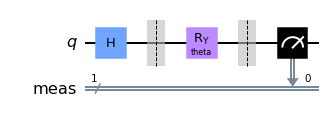

In [3]:
# Test the circuit

backend = Aer.get_backend('qasm_simulator')
circ = QuantumCircuit(backend, shots=100)
run = circ.run([np.pi])
print('Expected value for pi rotation: {}'.format(run))

circ._circuit.draw()

In [4]:
# We need to write the forward and backward pass for our hybrid circuit

class HybridForwardBackward(Function):
    
    @staticmethod
    def forward(ctx, X, qc, s):
        '''Compute forward pass through the entire circuit. 
        X is the input data, qc is the quantum circuit, s is the shift parameter'''
        ctx.s = s
        ctx.qc = qc
        
        out = torch.tensor([ctx.qc.run(X[0].tolist())])
        ctx.save_for_backward(X, out)
        
        return out
    
    @staticmethod
    def backward(ctx, grad_output):
        X, E = ctx.saved_tensors
        X_list = np.array(X.tolist())
        
        pos_shift = X_list + ctx.s * np.ones(X_list.shape)
        neg_shift = X_list - ctx.s * np.ones(X_list.shape)
        
        grads = []
        
        for k in range(len(X_list)):
            pos_E = ctx.qc.run(pos_shift[k])
            neg_E = ctx.qc.run(neg_shift[k])
            
            grads.append(torch.tensor([pos_E]) - torch.tensor([neg_E]))
            
        grads = np.array([grads]).T
        grads = torch.FloatTensor(grads).T
        
        return grads * grad_output.float(), None, None

In [5]:
# Defining the pass through the quantum circuit
class Hybrid(nn.Module):
    
    def __init__(self, backend, shots, s):
        super(Hybrid, self).__init__()
        
        self.qc = QuantumCircuit(backend, shots)
        self.s = s
        
    def forward(self, X):
        return HybridForwardBackward.apply(X, self.qc, self.s)

In [6]:
# We will be working with the MNIST dataset

transform = transforms.Compose([transforms.ToTensor()])
mnist_train = torchvision.datasets.MNIST(root='.', train=True, download=True, transform=transform)
mnist_test = torchvision.datasets.MNIST(root='.', train=False, download=True, transform=transform)

In [7]:
# Only differenciate between 2 and 8
num_samples = 100 # otherwise takes way too long

index_train = np.append(np.where(mnist_train.targets==0)[0][:num_samples],
                      np.where(mnist_train.targets==1)[0][:num_samples])

mnist_train.data = mnist_train.data[index_train]
mnist_train.targets = mnist_train.targets[index_train]

index_test = np.append(np.where(mnist_test.targets==0)[0][:num_samples],
                      np.where(mnist_test.targets==1)[0][:num_samples])

mnist_test.data = mnist_test.data[index_test]
mnist_test.targets = mnist_test.targets[index_test]

In [8]:
batch_size = 1 

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

In [9]:
# here we define the preprocessing qand integrate the hybrid circuit. For preprocessind, we use a CNN

class PQC(nn.Module):
    
    def __init__(self):
        super(PQC, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d((2,2))
            )
        
        self.classifier = nn.Sequential(
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1))
        
        self.hybrid = Hybrid(Aer.get_backend('qasm_simulator'), shots=100, s=np.pi/2)
        
    def forward(self, X):
        bsize = X.size(0)
        features = self.features(X)
        x = features.view(bsize, -1)
        x = self.classifier(x)
        out = self.hybrid(x)
        return torch.cat((out, 1-out), -1) # this is the final prediction as provided by the measurement

In [10]:
model = PQC()
optim = optimizer.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss() # this is the negative log likelihood

epochs = 5
train_losses = []

model.train()
for epoch in range(epochs):
    loss_total = []
    for i, (inp, target) in enumerate(train_loader):
        optim.zero_grad()
        out = model(inp)
        loss = criterion(out, target)
        loss.backward()
        optim.step()
        
        loss_total.append(loss)
    epoch_loss = sum(loss_total)/len(loss_total)
    print('Epoch {} \t Loss {}'.format(epoch, epoch_loss))

/tmp/ipykernel_60/855516647.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  out = torch.tensor([ctx.qc.run(X[0].tolist())])
/tmp/ipykernel_60/855516647.py:33: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  grads = np.array([grads]).T


Epoch 0 	 Loss -0.8134500000000005
Epoch 1 	 Loss -0.9819499999999999
Epoch 2 	 Loss -0.9897
Epoch 3 	 Loss -0.9913000000000003
Epoch 4 	 Loss -0.9946499999999999


Label: 1
Label: 1
Label: 1
Label: 0
Label: 1
Label: 1


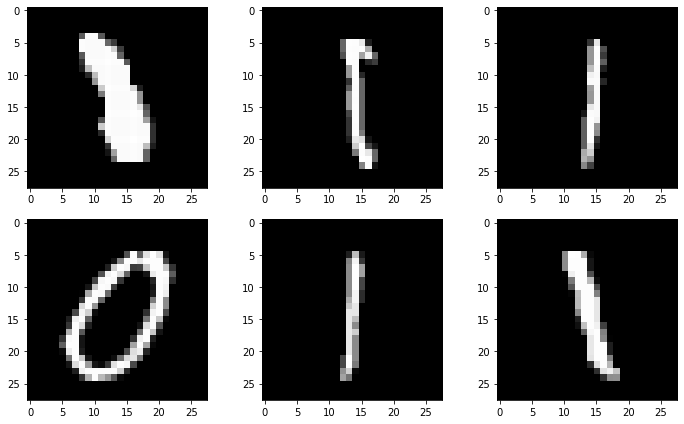

In [11]:
model.eval()
fig = plt.figure()

with torch.no_grad():
    
    for i in range(6):
        image, label = next(iter(test_loader))
        out = model(image)
        pred = out.argmax(dim=1, keepdim=True)
        
        lab = label[0]
        
        img = image[0].squeeze()
        
        ax = plt.subplot(2, 3, i+1)
        plt.tight_layout()
        plt.imshow(img, cmap='gray')
        print("Label: {}".format(lab))